# Load and run models

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd ../../geoarches

/work/bk1450/a270220/repos/geoarches/geoarches


In [4]:
from geoarches.lightning_modules import load_module

/work/bk1450/a270220/geoarches_env/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load ArchesWeather

In [5]:
# load_module will look in modelstore/
model, config = load_module("archesweather-m-seed0")

/work/bk1450/a270220/geoarches_env/lib64/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt


In [6]:
# we can also load the 4-members deterministic ensemble ArchesWeather-Mx4 like so:

model, config = load_module(
    "archesweather-m-seed0",
    avg_with_modules=[
        "archesweather-m-seed1",
        "archesweather-m-skip-seed0",
        "archesweather-m-skip-seed1",
    ],
)

Restored from modelstore/archesweather-m-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt


## Era5 Dataloader

In [7]:
# load sample from dataloader
from geoarches.dataloaders.era5 import Era5Forecast

ds = Era5Forecast(
    path="data/era5_240/full",  # default path
    load_prev=True,  # whether to load previous state
    norm_scheme="pangu",  # default normalization scheme
    domain="test",  # domain to consider. domain = 'test' loads the 2020 period
)

12it [00:12,  1.05s/it]

start time 2019-12-31T00:00:00


In [8]:
# The dataset returns a dict of TensorDict:
print("keys in a sample:", ds[0].keys())
# a state contains level and surface variables in a TensorDict, which is a specialized structure for dict of tensors
print("sample state", ds[0]["state"])

keys in a sample: dict_keys(['timestamp', 'state', 'lead_time_hours', 'next_state', 'prev_state'])
sample state TensorDict(
    fields={
        level: Tensor(shape=torch.Size([6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
        surface: Tensor(shape=torch.Size([4, 1, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


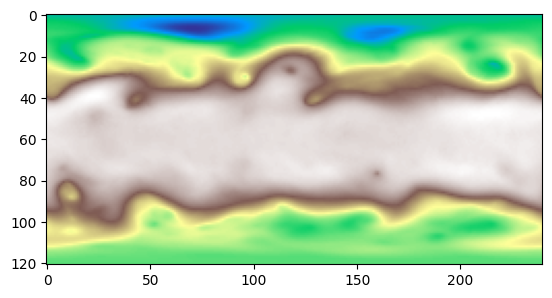

In [9]:
# we can visualize a sample, e.g. Z500, with the following

import matplotlib.pyplot as plt

plt.imshow(ds[0]["state"]["level"][0, 7], cmap="terrain")

## Run ArchesWeather

In [10]:
# now we can run inference with the deterministic model ArchesWeather:
import torch

torch.set_grad_enabled(False)

device = "cuda:0"

model = model.to(device)

batch = {k: v[None].to(device) for k, v in ds[0].items()}

pred = model(batch).cpu()

In [11]:
# optionally, we can denormalize the prediction to go back to real physical values
pred = ds.denormalize(pred)

24h Z500 prediction


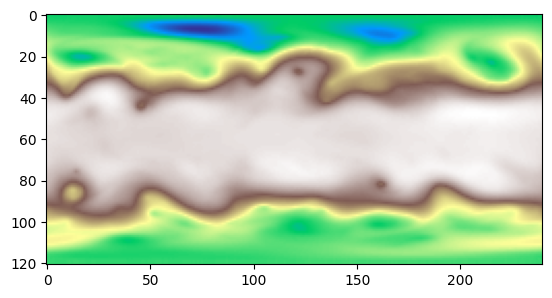

24h ground truth


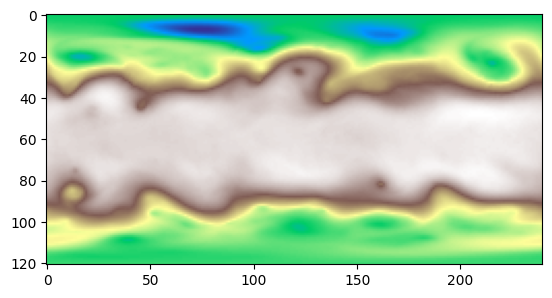

In [12]:
# we can visualize predictions, compared to ground truth

print("24h Z500 prediction")
plt.imshow(pred["level"][0, 0, 7], cmap="terrain")
plt.show()

print("24h ground truth")
plt.imshow(ds[0]["next_state"]["level"][0, 7], cmap="terrain")
plt.show()

In [14]:
# we can also do multistep rollouts with the deterministic model:
pred_multistep = model.forward_multistep(batch, iters=10)  # this does a 10-day rollout
# the rollout dimension is the second dimension in the predicted tensors
pred_multistep

TensorDict(
    fields={
        level: Tensor(shape=torch.Size([1, 10, 6, 13, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True),
        surface: Tensor(shape=torch.Size([1, 10, 4, 1, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1, 10]),
    device=cuda:0,
    is_shared=True)

## Loading and running ArchesWeatherGen

In [23]:
# loading ArchesWeatherFlow
device = "cuda:0"

# load_module will look in modelstore/
gen_model, gen_config = load_module("archesweathergen")

gen_model = gen_model.to(device)

Restored from modelstore/archesweather-m-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed0/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweather-m-skip-seed1/checkpoints/checkpoint.ckpt
Restored from modelstore/archesweathergen/checkpoints/checkpoint.ckpt


In [24]:
# run model on a sample
seed = 0
num_steps = 25  # if not provided to model.sample, model will use the default value (25)
scale_input_noise = 1.05

batch = {k: v[None].to(device) for k, v in ds[0].items()}


sample = gen_model.sample(
    batch, seed=seed, num_steps=num_steps, scale_input_noise=scale_input_noise
).cpu()

100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


In [26]:
sample

TensorDict(
    fields={
        level: Tensor(shape=torch.Size([1, 6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
        surface: Tensor(shape=torch.Size([1, 4, 1, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=cpu,
    is_shared=False)

In [38]:
print(sample["level"].shape)
print(sample["surface"].shape)

torch.Size([1, 6, 13, 121, 240])
torch.Size([1, 4, 1, 121, 240])


In [39]:
# Example: get names or info if available
print("level tensor dims:", sample["level"].shape)
print("surface tensor dims:", sample["surface"].shape)

level tensor dims: torch.Size([1, 6, 13, 121, 240])
surface tensor dims: torch.Size([1, 4, 1, 121, 240])


In [40]:
# Check time dim on level
print("Level tensor slice at time 0:", sample["level"][:, 0, :, :, :].mean())
print("Level tensor slice at time 1:", sample["level"][:, 1, :, :, :].mean())

Level tensor slice at time 0: tensor(-0.0529)
Level tensor slice at time 1: tensor(0.0659)


In [41]:
for key in sample.keys():
    print(f"{key}: shape {sample[key].shape}")

surface: shape torch.Size([1, 4, 1, 121, 240])
level: shape torch.Size([1, 6, 13, 121, 240])


In [45]:
for key in sample.keys():
    print(f"Key: {key}")
    print(f"Shape: {sample[key].shape}")

    for dim in range(len(sample[key].shape)):
        dim_size = sample[key].shape[dim]
        val0 = sample[key].select(dim, 0).mean()
        print(f"Mean at dim {dim}, index 0: {val0}")

        if dim_size > 1:
            val1 = sample[key].select(dim, 1).mean()
            print(f"Mean at dim {dim}, index 1: {val1}")
        else:
            print(f"Only one index at dim {dim}, skipping index 1")

        print("---")


Key: surface
Shape: torch.Size([1, 4, 1, 121, 240])
Mean at dim 0, index 0: -0.043440915644168854
Only one index at dim 0, skipping index 1
---
Mean at dim 1, index 0: 0.03165619447827339
Mean at dim 1, index 1: -0.06545151025056839
---
Mean at dim 2, index 0: -0.043440915644168854
Only one index at dim 2, skipping index 1
---
Mean at dim 3, index 0: -0.3385810852050781
Mean at dim 3, index 1: -0.40753164887428284
---
Mean at dim 4, index 0: 0.055920396000146866
Mean at dim 4, index 1: 0.03783704340457916
---
Key: level
Shape: torch.Size([1, 6, 13, 121, 240])
Mean at dim 0, index 0: 0.02032039873301983
Only one index at dim 0, skipping index 1
---
Mean at dim 1, index 0: -0.052880823612213135
Mean at dim 1, index 1: 0.06586126238107681
---
Mean at dim 2, index 0: 0.08527049422264099
Mean at dim 2, index 1: 0.061216674745082855
---
Mean at dim 3, index 0: -0.5782951712608337
Mean at dim 3, index 1: -0.6519232392311096
---
Mean at dim 4, index 0: 0.019045935943722725
Mean at dim 4, index

In [27]:
ds[0]

{'timestamp': tensor(1577836800, dtype=torch.int32),
 'state': TensorDict(
     fields={
         level: Tensor(shape=torch.Size([6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
         surface: Tensor(shape=torch.Size([4, 1, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False)},
     batch_size=torch.Size([]),
     device=None,
     is_shared=False),
 'lead_time_hours': tensor(24, dtype=torch.int32),
 'next_state': TensorDict(
     fields={
         level: Tensor(shape=torch.Size([6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
         surface: Tensor(shape=torch.Size([4, 1, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False)},
     batch_size=torch.Size([]),
     device=None,
     is_shared=False),
 'prev_state': TensorDict(
     fields={
         level: Tensor(shape=torch.Size([6, 13, 121, 240]), device=cpu, dtype=torch.float32, is_shared=False),
         surface: Tensor(shape=torch.Size([4, 1, 121, 240]), device=cpu, 

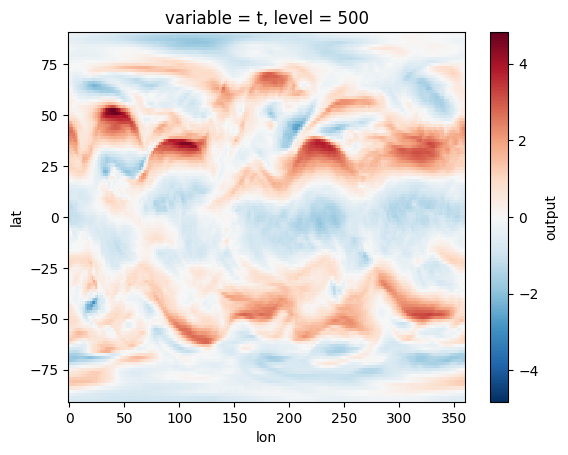

In [30]:
import xarray as xr
import numpy as np

# Assume: level_vars, pressure_levels, lat, lon 
data = sample['level'][0].numpy()  # shape: [6, 13, 121, 240]
level_vars = ["z", "t", "u", "v", "q", "w"]
pressure_levels = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
lat = np.linspace(90, -90, 121)
lon = np.linspace(0, 359, 240)

xr_data = xr.DataArray(
    data,
    dims=["variable", "level", "lat", "lon"],
    coords={
        "variable": level_vars,
        "level": pressure_levels,
        "lat": lat,
        "lon": lon,
    },
    name="output"
)

xr_data.sel(variable="t", level=500).plot()  # Plot 500 hPa temperature


In [36]:
test = sample.convert_trajectory_to_xarray(sample)

AttributeError: 'TensorDict' object has no attribute 'convert_trajectory_to_xarray'

In [33]:
# Extract preds_future for "level" only, batch 0
preds_level = sample_tensordict["level"][0]  # shape: [6, 13, 121, 240]

# Add batch dim back to match expected shape (batch, time, vars, lat, lon)
# Actually, convert_trajectory_to_xarray expects batch dim in the input tensordict,
# so better wrap in a tensordict or tensor with batch dim:

import torch
from tensordict import TensorDict

# Wrap preds_level back with batch dimension for consistency
preds_level_batch = preds_level.unsqueeze(0)  # shape [1, 6, 13, 121, 240]

# Wrap in a tensordict with the same key, if required
preds_future_tensordict = TensorDict(
    {
        "level": preds_level_batch
    },
    batch_size=[1],
)

# Provide a timestamp tensor, e.g., Jan 1 2020 in UNIX time (seconds since epoch)
timestamp = torch.tensor(1577836800)  # Jan 1 2020

# Now call conversion on the level preds
xarray_ds = dataset.convert_trajectory_to_xarray(
    preds_future=preds_future_tensordict["level"],  # or just preds_level_batch
    timestamp=timestamp,
    denormalize=True,
    levels=[500, 700, 850],  # or your desired levels
)

print(xarray_ds)

NameError: name 'sample_tensordict' is not defined

In [25]:
# run a model auto-regressively

rollout_iterations = 10
n_members = 10

sample_multistep = [
    gen_model.sample_rollout(
        batch,
        batch_nb=0,  # should be different for each input
        member=i,
        iterations=rollout_iterations,
    )
    for i in range(n_members)
]

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


In [46]:
sample_multistep

[TensorDict(
     fields={
         level: Tensor(shape=torch.Size([1, 10, 6, 13, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True),
         surface: Tensor(shape=torch.Size([1, 10, 4, 1, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True)},
     batch_size=torch.Size([1, 10]),
     device=cuda:0,
     is_shared=True),
 TensorDict(
     fields={
         level: Tensor(shape=torch.Size([1, 10, 6, 13, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True),
         surface: Tensor(shape=torch.Size([1, 10, 4, 1, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True)},
     batch_size=torch.Size([1, 10]),
     device=cuda:0,
     is_shared=True),
 TensorDict(
     fields={
         level: Tensor(shape=torch.Size([1, 10, 6, 13, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True),
         surface: Tensor(shape=torch.Size([1, 10, 4, 1, 121, 240]), device=cuda:0, dtype=torch.float32, is_shared=True)},
     batch_size=torch.Size([1, 10])

In [49]:
sample_td = sample_multistep[0]  # pick one example

level_tensor = sample_td["level"]    # shape: [1, 10, 6, 13, 121, 240]
surface_tensor = sample_td["surface"]  # shape: [1, 10, 4, 1, 121, 240]

# If your function can handle a dict, pass it directly,
# else combine along the var dimension (dim=2), padding levels if needed.

# Just example if combining along var dimension, you'd need to pad surface level dim to 13 for example,
# or process separately.

# Pass `level_tensor` or `surface_tensor` or both to your function:
xr_ds = sample_multistep.convert_trajectory_to_xarray(level_tensor, timestamp=..., denormalize=True)

AttributeError: 'list' object has no attribute 'convert_trajectory_to_xarray'